# Imports

In [ ]:
import math
import numpy as np
import plotly.express as px
import warnings

warnings.filterwarnings('ignore')

try:  
    from neel_plotly import imshow, scatter 
except ImportError:
    print("neel_plotly not found, installing it now...")
    %pip install git+https://github.com/neelnanda-io/neel-plotly.git
    
import torch

import random
from functools import partial
import einops

from rich.table import Table, Column
from rich import print as rprint
from IPython.display import HTML

import transformer_lens.utils as utils
from transformer_lens import HookedTransformer

torch.set_grad_enabled(False)
print("Disabled automatic differentiation")

# all these are taken from https://github.com/callummcdougall/ARENA_2.0/blob/main/chapter0_fundamentals/exercises/plotly_utils.py
update_layout_set = {"xaxis_range", "yaxis_range", "yaxis2_range", "hovermode", "xaxis_title", "yaxis_title", "colorbar", "colorscale", "coloraxis", "title_x", "bargap", "bargroupgap", "xaxis_tickformat", "yaxis_tickformat", "title_y", "legend_title_text", "xaxis_showgrid", "xaxis_gridwidth", "xaxis_gridcolor", "yaxis_showgrid", "yaxis_gridwidth", "yaxis_gridcolor", "showlegend", "xaxis_tickmode", "yaxis_tickmode", "margin", "xaxis_visible", "yaxis_visible", "bargap", "bargroupgap", "xaxis_tickangle"}
from transformer_lens.utils import to_numpy

def bar(tensor, renderer=None, **kwargs):
    '''
    '''
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    px.bar(y=to_numpy(tensor), **kwargs_pre).update_layout(**kwargs_post).show(renderer)

def line(tensor, **kwargs):
    px.line(
        y=utils.to_numpy(tensor),
        **kwargs,
    ).show()

def scatter(x, y, xaxis="", yaxis="", caxis="", **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(
        y=y,
        x=x,
        labels={"x": xaxis, "y": yaxis, "color": caxis},
        **kwargs,
    ).show()

%load_ext autoreload
%autoreload 2

Disabled automatic differentiation


This notebook demonstrates a set of core mechanistic interpretability methods using the **Indirect Object Identification (IOI)** task:
- **Universal Tools**: general-purpose methods that can be applied to arbitrary prompts and tasks.


# Note

This notebook assumes familiarity with basic Transformer components (residual stream, attention heads, MLPs) and introduces & explains (IMO) valuable interpretability tools to analyze and reverse-engineer Transformers. For any unfamiliar terms, refer to Neel Nanda’s [glossary](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=disz2gTx-jooAcR0a5r8e7LZ£), or TransformerLens docs.

Some of the technical explanations are either taken directly from companion or tutorial notebooks from [TransformerLens](https://transformerlensorg.github.io/TransformerLens/) or other researchers (which I hope that I managed to cite) or paraphrased and adapted to my reimplementation of the method. I also want add that for simple stuff, e.g. defining the prompt dataset with corruption, I did not mention the source because this would've undoubtedly lead to a overflowing with many references.

# Setup

In [2]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",   
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=False,
)     
device: torch.device = utils.get_device()
model = model.to(device)                         

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


## Task Setup

We are going to use IOI task in order to exemplify our selected interpretability methods, which we gathered from various resources (cited in the README and throughout the notebook) and centralized in this repo, and as a bonus replicate the findings of the paper (from Callum McDougall's [ARENA tutorial](https://colab.research.google.com/drive/1AA0wj2sHoZwtmy82WXORcZzk9urL1lVA#scrollTo=jHjUFdAPl6ma)). 

The IOI task has been extensively studied in interpability literature, with studies ranging from causal mediation analysis (https://arxiv.org/pdf/2211.00593, https://arxiv.org/pdf/2304.05969, https://arxiv.org/pdf/2305.15054, https://arxiv.org/pdf/2403.00745v1) to mechanistic universality (https://arxiv.org/pdf/2310.08744) and explaining attention heads (https://arxiv.org/pdf/2310.04625, https://arxiv.org/pdf/2312.09230) and emergent model behavior (https://arxiv.org/pdf/2307.15771), and as a benchmark for automatic circuit discovery (https://arxiv.org/pdf/2304.14997) and for circuits formed in sparse training (https://arxiv.org/pdf/2505.00509). 

It is a subject-verb-object task in natural language simple enough to reverse-engineer (albeit using SLMs). Concretely given the sentence `When John and Mary went to the shops, John gave the bag to ...` we expect the model to return Mary, i.e. the indirect object, inferring that the IO is the name for which the subject, John is performing the action towards. This allows for forming the hypothesis that in order to answer correctly, the language model should count the number of appearances of each name and output the name that occurs only once. This is in fact the behavior that the [IOI paper](https://arxiv.org/pdf/2211.00593) found and explained in GPT-2 Small (124M parameters). 

This type of natural language task requires the model to choose the answer from the context (appropriately named and frequently used in lit as In-Context Learning; `ICL`), irrespective of factual information about perhaps semantics, favoring instead surface-level heuristics (e.g. frequency statistics: n-grams), but this is only a possible plausible solution from many more complicated ones.

Below we use the `test_prompt` function that returns the top-k probabilities of token following the last token in the prompt and we see a rank difference of 4 between the correct answer ` Mary` (important, with prepended space) and the incorrect answer `John`, and a 67.5 % difference in probability and 4.2 in log probabilities (or logits), i.e. a $e^{4.2}\approx 67\times$ higher probability on the correct answer.

In [3]:
utils.test_prompt(model=model, prompt="When John and Mary went to the shops, John gave the bag to", answer=" Mary")

Tokenized prompt: ['<|endoftext|>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' John', ' gave', ' the', ' bag', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 18.19 Prob: 69.93% Token: | Mary|

Top 0th token. Logit: 18.19 Prob: 69.93% Token: | Mary|
Top 1th token. Logit: 15.82 Prob:  6.49% Token: | them|
Top 2th token. Logit: 15.48 Prob:  4.66% Token: | the|
Top 3th token. Logit: 14.93 Prob:  2.66% Token: | his|
Top 4th token. Logit: 14.86 Prob:  2.49% Token: | John|
Top 5th token. Logit: 14.12 Prob:  1.19% Token: | her|
Top 6th token. Logit: 13.99 Prob:  1.04% Token: | their|
Top 7th token. Logit: 13.70 Prob:  0.78% Token: | a|
Top 8th token. Logit: 13.53 Prob:  0.66% Token: | him|
Top 9th token. Logit: 13.39 Prob:  0.57% Token: | Mrs|


Ranks of the answer tokens: [(' Mary', 0)]

All methods needs a special formatting of the task into prompts and answers tokens in pairs of **correct/incorrect** answers. See the example below: 

- All prompts are recommanded to be of equal length, if possible. 
- If working with prompts of variable lengths, there is the option of performing padding on the left side of the prompt, such that the end tokens are at the exact token position. By default, padding is done by adding the flag: `model.to_tokens(prompts, padding_side='left')` which automatically pads up to the maximum length from all prompts.

In [4]:
prompt_format = [
    "When John and Mary went to the shops,{} gave the bag to",
    "When Tom and James went to the park,{} gave the ball to",
    "When Dan and Sid went to the shops,{} gave an apple to",
    "After Martin and Amy went to the park,{} gave a drink to",
]
name_pairs = [
    (" Mary", " John"),
    (" Tom", " James"),
    (" Dan", " Sid"),
    (" Martin", " Amy"),
]

# Define 8 prompts, in 4 groups of 2 (with adjacent prompts having answers swapped)
prompts = [
    prompt.format(name)
    for (prompt, names) in zip(prompt_format, name_pairs) for name in names[::-1]
]
# Define the answers for each prompt, in the form (correct, incorrect)
answers = [names[::i] for names in name_pairs for i in (1, -1)]
# Define the answer tokens (same shape as the answers)
answer_tokens = torch.concat([
    model.to_tokens(names, prepend_bos=False).T for names in answers
])

tokens = model.to_tokens(prompts, prepend_bos=True)
tokens = tokens.to(device)

original_logits, cache = model.run_with_cache(tokens)

rprint(prompts)
rprint(answers)
rprint(answer_tokens)
rprint(tokens.shape)

[
    'When John and Mary went to the shops, John gave the bag to',
    'When John and Mary went to the shops, Mary gave the bag to',
    'When Tom and James went to the park, James gave the ball to',
    'When Tom and James went to the park, Tom gave the ball to',
    'When Dan and Sid went to the shops, Sid gave an apple to',
    'When Dan and Sid went to the shops, Dan gave an apple to',
    'After Martin and Amy went to the park, Amy gave a drink to',
    'After Martin and Amy went to the park, Martin gave a drink to'
]

[
    (' Mary', ' John'),
    (' John', ' Mary'),
    (' Tom', ' James'),
    (' James', ' Tom'),
    (' Dan', ' Sid'),
    (' Sid', ' Dan'),
    (' Martin', ' Amy'),
    (' Amy', ' Martin')
]

tensor([[ 5335,  1757],
        [ 1757,  5335],
        [ 4186,  3700],
        [ 3700,  4186],
        [ 6035, 15686],
        [15686,  6035],
        [ 5780, 14235],
        [14235,  5780]], device='cuda:0')

torch.Size([8, 15])

# Universal Interpretability Tools (Prompt-Agnostic)

These methods analyze internal model behavior without assuming any specific task structure, such as the IOI where we have names with predefined attributes such as Subject or Indirect Object. They can be applied to any prompt to get insight both quantitatively and qualitatevly about what the model "knows" and "thinks" at different layers or components.

We use an IOI prompt here for illustration, but this method works for any arbitrary prompt, provided that we perform the previous task setup steps.

## Observational Methods

### Logit Lens

This is a visual representation of the logit lens, in similar fashion to the tables in the [**logit lens**](https://www.alignmentforum.org/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens) article and adapted from the [notebook](https://colab.research.google.com/drive/1-ApGJPKUN3S81kv7g9pQIKH217M0sSPJ#scrollTo=TBcRhOtCrmiC) companion for the Successor Heads paper by [Gould et al. (2023)](https://arxiv.org/pdf/2312.09230) (the notebook is linked in this LessWrong [blog post](https://www.lesswrong.com/posts/6tHNM2s6SWzFHv3Wo/mechanistically-interpreting-time-in-gpt-2-small)). In this method we can take any activation from the Transformer of inner dimension = `d_model` and project it onto the vocabulary space by multiplying by the unembedding matrix (shape [`d_model`, `d_vocab`]), yielding an interpretable space that simulates *intermediary predictions* of the model, i.e. what the model would predict if forced to make a decision at that point. 

<details><summary>Technical details</summary>

We actually need to apply Layernorm scaling before the Unembedding (see this [section](https://github.com/TransformerLensOrg/TransformerLens/blob/ddd0ee7b4bf51e7a5493b39bdb663978234ed1f0/further_comments.md?plain=1#L8) about LayerNorm in the TransformerLens docs), just as it is done at the final layer: 

`logits = Unembed(LayerNorm(final_residual_stream))`, so we technically need to account for the centering, and then learned translation and scaling of the layernorm, not just the variance 1 scaling.

The centering is accounted for with the preprocessing flag `center_writing_weights` which ensures that every weight matrix writing to the residual stream has mean zero.

The learned scaling is folded into the unembedding weights `model.unembed.W_U` via `W_U_fold = layer_norm.weights[:, None] * unembed.W_U`

The learned translation is folded to `model.unembed.b_U`, a bias added to the logits (note that GPT-2 is not trained with an existing `b_U`). This roughly represents unigram statistics. But we can ignore this because each prompt occurs twice with names in the opposite order, so this perfectly cancels out.

Note that rather than using layernorm scaling we could just study cache["ln_final.hook_normalised"]. 

</details>

</details>

`!` The difference between **Logit Lens** and **Logit Difference** is that Logit Lens is simply a visualization tool for inspecting intermediate activations of the Transformer qualitatively (and quantitatively if we add logits values to the plotted top-k tokens), whereas Logit Difference is a quantitative method for measuring if the model favors a *response* (that we choose) over an *incorrect or inplausible one* (also). The similarity between them is that they are applied to the same type of activations and apply unembedding (and LN operations; scaling and shifting).


Function details:

<span style="color:yellow;">**visual_logit_lens**</span>:

- <span style="background-color: blue;">model</span>
- <span style="background-color: blue;">prompts</span>: the list of prompts
- <span style="background-color: blue;">k</span>:  how many top tokens we want to plot 
- <span style="background-color: blue;">logits_or_probs</span>: whether to show the logits or probabilities of the top-k tokens 
- <span style="background-color: blue;">decomposition</span>: We can select the type of decomposition of the residual stream. Available options are: 

    - <span style="background-color: hsl(0 100% 20%);">resid_post</span> : The final residual stream state, after MLP
    - <span style="background-color: hsl(0 100% 20%);">attention_out</span> : Attention output before adding the result to the residual stream vector
    - <span style="background-color: hsl(0 100% 20%);">mlp_out</span> : MLP output before multiplying by W_out_mlp (check the forward pass in `transformer_lens.components.mlp`) and adding the result to the residual stream vector
    - <span style="background-color: hsl(0 100% 20%);">attention_heads</span> : Attention head output before adding the result to the residual stream vector

In [5]:
from src.observational.direct_logit_attribution import visual_logit_lens

str_tokens = model.to_str_tokens(tokens[0])
titles = [f"{token1} -> {token2}" for token1, token2 in zip(str_tokens[:-1], str_tokens[1:])]
print(str_tokens)
correct_ids = []
for i in range(1, len(str_tokens) + 1):
    correct_ids.extend(model.tokenizer.encode(f" {str_tokens[i % len(str_tokens)]}")) 

visual_logit_lens(model, prompts[0], decomposition='resid_post', k=3, logits_or_probs='probs', titles=titles)

['<|endoftext|>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' John', ' gave', ' the', ' bag', ' to']


### Vocabulary Projection

Vocabulary projection is a  tool used to inspect what information is encoded at a specific place in the Transformer. It is conceptually related to the *logit lens* method, in which internal activations are projected through the final unembedding matrix to obtain a probability distribution over the vocabulary.

As noted by the nostalgebraist, the author of the [logit lens](https://www.alignmentforum.org/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens) article:

> "These distributions gradually converge to the final distribution over the layers of the Transformer, often getting close to that distribution long before the end [...] this suggests that GPT mostly 'thinks in predictive space,' immediately converting inputs to predicted outputs, then refining guesses in light of other guesses that are themselves being refined."

<details><summary>Technical details</summary>

Let $A_{\text{pos},\, \text{dim}} \in \mathbb{R}^{L \times d}$ denote the activation vector at a given position in the sequence and a specific component in the Transformer (e.g., attention head output, MLP output, residual stream). We project this activation into the vocabulary space using the unembedding matrix $\mathbf{W}_U \in \mathbb{R}^{d \times |\mathcal{V}|}$ (introduced in [Dar et al. (2022)](https://arxiv.org/pdf/2209.02535)):

$
\mathbf{A}_{\text{vocab}} = A_{\text{pos},\, \text{dim}} \cdot \mathbf{W}_U
$

This results in:

$
\mathbf{A}_{\text{vocab}} \in \mathbb{R}^{L \times |\mathcal{V}|}
$

To interpret this vector as a probability distribution over tokens, we apply a softmax:

$
P_{\text{token}}(t \mid \text{layer}, \text{pos}) = \text{softmax}(\mathbf{A}_{\text{vocab}})
$

This process treats the intermediate activation as if it were the final hidden state and decodes it to predict the next token. This is sometimes referred to as **early decoding**.

#### MLP Neuron Projections

To inspect a **single MLP neuron** we can isolate its activation by zeroing out all other neurons in the activation vector:

$
A'_{\text{pos},\, i} =
\begin{cases}
A_{\text{pos},\, i} & \text{if } i = k \text{ (selected neuron)} \\
0 & \text{otherwise}
\end{cases}
$

Then project $A'$ into vocabulary space:

$\mathbf{A}'_{\text{resid\_post}} = A'_{\text{pos},\, d_{\mathrm{mlp}}} \cdot \mathbf{W}_{\text{out}}$, where $\mathbf{W}_{\text{out}}$ has shape [$d_{\mathrm{model}}$, $d_{\mathrm{mlp}}$]

And finally $\mathbf{A}'_{\text{vocab}} = \mathbf{A}'_{\text{resid\_post}} \cdot \mathbf{W}_U$,

Because doing

$
\mathbf{A}'_{\text{vocab}} = A'_{\text{pos},\, d_{\mathrm{mlp}}} \cdot \mathbf{W}_U
$
will result in a shape mismatch, for the inner dimensions `mlp.hook_post` of shape [$\mathrm{seq}$, $d_{\mathrm{mlp}}$] and `model.W_U` [$d_{\mathrm{model}}$, $d_{\mathrm{vocab}}$] do not match.

This reveals which tokens are most activated by the presence of that neuron alone. So this section is just a reiteration of the **Logit Lens** that supports a finer-grained analysis of MLP neurons that also provides some intuition about the types of activations that we are allowed to analyze with this method.

</details>

Function details: 

<span style="color: yellow">**vocabulary_projection**</span>: Takes in a single `prompt`, `model` and `tokenizer`

- <span style="background-color: blue">**method**</span>: How to perform the projection. Options:
    - <span style="background-color: hsl(0 100% 20%);">unembedding</span>: Apply final layer norm and project using W_U.
    - <span style="background-color: hsl(0 100% 20%);">top-k</span>: Just apply softmax directly to the hidden state.
- <span style="background-color: blue">**top-k**</span>: Number of top predicted tokens to return at each position
- <span style="background-color: blue">**all_tok_pos**</span>: 
    - If <span style="background-color: hsl(0 100% 20%);">True</span>, return top-k tokens for every token in the prompt.
    - If <span style="background-color: hsl(0 100% 20%);">False</span>, return only for the final token.
- <span style="background-color: blue">**specific_activation**</span>: Identifier for which module to hook into: Supported formats:
    - Residual stream: <span style="background-color: hsl(0 100% 20%);">L9.Resid_Pre</span> (Before Attention), <span style="background-color: hsl(0 100% 20%);">L9.Resid_Mid</span> (After Attention), <span style="background-color: hsl(0 100% 20%);">L9.Resid_Post</span> (After MLP)
    - MLP: <span style="background-color: hsl(0 100% 20%);">L9.MLP_In</span>, <span style="background-color: hsl(0 100% 20%);">L9.MLP_Out</span> (of shape [`batch`, `pos`, `d_mlp`])
    - Attention output: <span style="background-color: hsl(0 100% 20%);">L9.Attn_Output</span>
    - Attention heads: <span style="background-color: hsl(0 100% 20%);">L9.H9.Q</span>, <span style="background-color: hsl(0 100% 20%);">L9.H9.K</span>, <span style="background-color: hsl(0 100% 20%);">L9.H9.V</span>, <span style="background-color: hsl(0 100% 20%);">L9.H9.Z</span> (this is the Attention Head output before summing into MHSA)
- <span style="background-color: blue">**neuron**</span>: If set, isolate the influence of a single user chosen neuron at that position.

In [6]:
from src.observational.vocab_projection import vocabulary_projection

results, activation = vocabulary_projection(
    prompt=prompts[0],
    model=model,
    tokenizer=model.tokenizer,
    method="top-k",
    top_k=10,
    all_tok_pos=True,
    specific_activation="L9.Attn_Output",
    neuron=87,
)

str_tokens = model.to_str_tokens(prompts[0])
for tok, top_preds in zip(str_tokens, results):
    best_tok, prob = top_preds[0]
    print(f"Token: {tok}, Predicted: {best_tok}, Prob: {prob * 100:.4f}%")

Token: <|endoftext|>, Predicted: (, Prob: 0.1302%
Token: When, Predicted: (, Prob: 0.1302%
Token:  John, Predicted: (, Prob: 0.1302%
Token:  and, Predicted: (, Prob: 0.1302%
Token:  Mary, Predicted: (, Prob: 0.1302%
Token:  went, Predicted: (, Prob: 0.1302%
Token:  to, Predicted: (, Prob: 0.1302%
Token:  the, Predicted: (, Prob: 0.1302%
Token:  shops, Predicted: (, Prob: 0.1302%
Token: ,, Predicted: (, Prob: 0.1302%
Token:  John, Predicted: (, Prob: 0.1302%
Token:  gave, Predicted: (, Prob: 0.1302%
Token:  the, Predicted: (, Prob: 0.1302%
Token:  bag, Predicted: x, Prob: 0.1314%


#### MLP Neuron Firing

We can now plot the activation of a single MLP neuron for all prompts across all token positions, but before we need to create a dictionary that maps words (corresponding to IOI names) to token positions and we do so below (however, manually indexing, because we used the same template: Subject -> Indirect Object -> Subject; this serves as an example for when having to deal with a fixed prompt template where we can allow ourselves to do primitive indexing). 

In [7]:
from src.utils import build_position_dicts_from_token_ids

toks = model.to_tokens(prompts, prepend_bos=True)
position_dicts = build_position_dicts_from_token_ids(toks)

all_str_tokens = model.to_str_tokens(prompts, prepend_bos=True)
# Verify that the mapping from word to position is correct
for i, str_tok in enumerate(all_str_tokens):
    print(f"Prompt {i}: {str_tok}")
    print(f"S1: {str_tok[position_dicts[i]['S1'].item()]}")
    print(f"IO: {str_tok[position_dicts[i]['IO'].item()]}")
    print(f"S2: {str_tok[position_dicts[i]['S2'].item()]}")
    print(f"end: {str_tok[position_dicts[i]['end'].item()]}")
    print(f"starts: {str_tok[position_dicts[i]['starts'].item()]}")
    if i == 0: 
        break

Prompt 0: ['<|endoftext|>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' John', ' gave', ' the', ' bag', ' to']
S1:  John
IO:  Mary
S2:  John
end:  to
starts: When


Function details: 

<span style='color: yellow'>plot_neuron_activation</span> takes in the `model`, `cache`, `tokenizer` and `tokens`

- <span style="background-color: blue">**layer**</span>: The layer of the MLP
- <span style="background-color: blue">**neuron_idx**</span>: The neuron from the MLP output activation (shape [`batch`, `pos`, `d_mlp`])
- <span style="background-color: blue">**prompt_idx**</span>: The id of the prompt for when we loop through all prompts
- <span style="background-color: blue">**target_word**</span>: Specify the word from the prompt that we want to highlight in red, useful if we want to keep track of a word that appears in multiple prompts

Token ' Mary' at position 4 labeled as IO. Activation: -0.1643


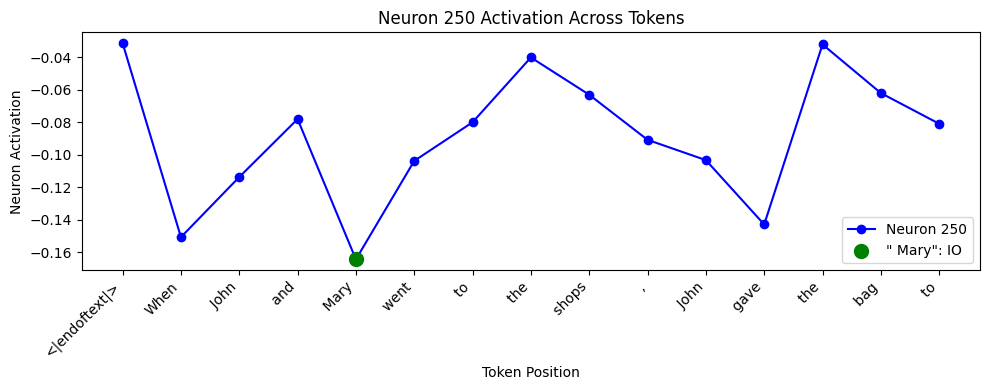

Token ' Mary' at position 4 labeled as IO. Activation: -0.1643


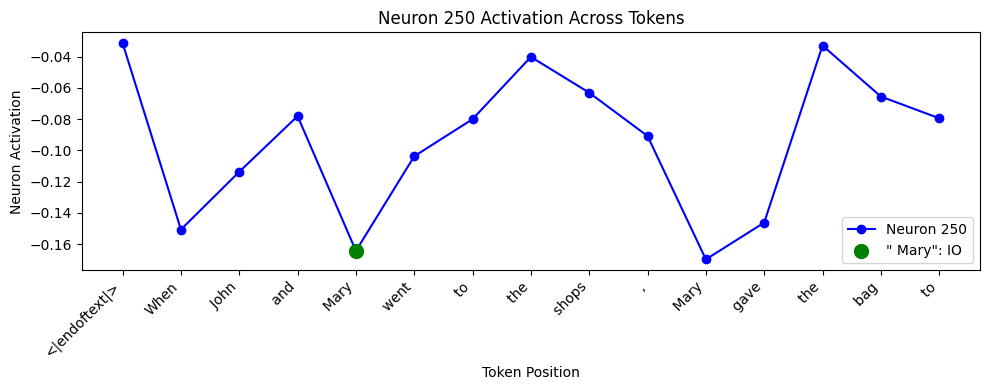

In [8]:
from src.observational.neuron import plot_neuron_activation

for id in range(tokens.shape[0]):
    plot_neuron_activation(
        model=model, 
        clean_cache=cache, 
        tokenizer=model.tokenizer, 
        clean_tokens=tokens,
        layer=0,  
        neuron_idx=250, 
        prompt_idx=id,           
        target_roles=['IO'],
        position_dict=position_dicts[0],
        # save=False
    )
    if id == 1:
        break

The code below is taken from this [colab](https://colab.research.google.com/drive/1_tH4PfRSPYuKGnJbhC1NqFesOYuXrir_#scrollTo=R67U29-hEXYN) which explains the functionalities of the HookedTransformer class (although from the older [EasyTransformer codebase](https://github.com/redwoodresearch/Easy-Transformer)).

Each hook point has a dictionary `hook.ctx` that can be used to store information between runs - this is useful for keeping running totals, etc.

For example, computing a running total of times a neuron activation was positive:

In [9]:
model.reset_hooks()
layer = 0
neuron_index = 250
def running_total_hook(neuron_acts, hook):
    if 'total' not in hook.ctx:
        hook.ctx['total']=0
    print('Neuron acts:', neuron_acts[0, :, neuron_index])
    hook.ctx['total']+=(neuron_acts[0, :, neuron_index]>0).sum().item()
    print('Running total positive:', hook.ctx['total'])

for prompt in prompts:
    print(model.to_str_tokens(prompt))
    model.run_with_hooks(prompts, fwd_hooks=[(f'blocks.{layer}.mlp.hook_post', running_total_hook)])

['<|endoftext|>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' John', ' gave', ' the', ' bag', ' to']
Neuron acts: tensor([-0.0314, -0.1507, -0.1137, -0.0781, -0.1643, -0.1038, -0.0801, -0.0402,
        -0.0631, -0.0908, -0.1033, -0.1429, -0.0322, -0.0621, -0.0810],
       device='cuda:0')
Running total positive: 0
['<|endoftext|>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' Mary', ' gave', ' the', ' bag', ' to']


Neuron acts: tensor([-0.0314, -0.1507, -0.1137, -0.0781, -0.1643, -0.1038, -0.0801, -0.0402,
        -0.0631, -0.0908, -0.1033, -0.1429, -0.0322, -0.0621, -0.0810],
       device='cuda:0')
Running total positive: 0
['<|endoftext|>', 'When', ' Tom', ' and', ' James', ' went', ' to', ' the', ' park', ',', ' James', ' gave', ' the', ' ball', ' to']
Neuron acts: tensor([-0.0314, -0.1507, -0.1137, -0.0781, -0.1643, -0.1038, -0.0801, -0.0402,
        -0.0631, -0.0908, -0.1033, -0.1429, -0.0322, -0.0621, -0.0810],
       device='cuda:0')
Running total positive: 0
['<|endoftext|>', 'When', ' Tom', ' and', ' James', ' went', ' to', ' the', ' park', ',', ' Tom', ' gave', ' the', ' ball', ' to']
Neuron acts: tensor([-0.0314, -0.1507, -0.1137, -0.0781, -0.1643, -0.1038, -0.0801, -0.0402,
        -0.0631, -0.0908, -0.1033, -0.1429, -0.0322, -0.0621, -0.0810],
       device='cuda:0')
Running total positive: 0
['<|endoftext|>', 'When', ' Dan', ' and', ' Sid', ' went', ' to', ' the', ' shops', ',', ' 

Finding the dataset example that most activates a given neuron: 

In [10]:
model.reset_hooks(clear_contexts=True)

layer = 0
neuron_index = 250
def best_act_hook(neuron_acts, hook, text):
    if 'best' not in hook.ctx:
        hook.ctx['best']=-1e3
    print('Neuron acts:', neuron_acts[0, :, neuron_index])
    if hook.ctx['best']<neuron_acts[0, :, neuron_index].max():
        print(f'Updating best act from {hook.ctx["best"]} to {neuron_acts[0, :, neuron_index].max().item()}')
        hook.ctx['best'] = neuron_acts[0, :, neuron_index].max().item()
        hook.ctx['text'] = text

for prompt in prompts:
    (print(model.to_str_tokens(prompt)))
    # Use partial to give the hook access to the relevant text
    model.run_with_hooks(prompt, fwd_hooks=[(f'blocks.{layer}.mlp.hook_post', partial(best_act_hook, text=prompt))])
print()
print('Maximally activating dataset example:', model.hook_dict[f'blocks.{layer}.mlp.hook_post'].ctx['text'])
model.reset_hooks(clear_contexts=True)

['<|endoftext|>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' John', ' gave', ' the', ' bag', ' to']
Neuron acts: tensor([-0.0314, -0.1507, -0.1137, -0.0781, -0.1643, -0.1038, -0.0801, -0.0402,
        -0.0631, -0.0908, -0.1033, -0.1429, -0.0322, -0.0621, -0.0810],
       device='cuda:0')
Updating best act from -1000.0 to -0.03143453970551491
['<|endoftext|>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' Mary', ' gave', ' the', ' bag', ' to']
Neuron acts: tensor([-0.0314, -0.1507, -0.1137, -0.0781, -0.1643, -0.1038, -0.0801, -0.0402,
        -0.0631, -0.0908, -0.1698, -0.1462, -0.0330, -0.0656, -0.0795],
       device='cuda:0')
['<|endoftext|>', 'When', ' Tom', ' and', ' James', ' went', ' to', ' the', ' park', ',', ' James', ' gave', ' the', ' ball', ' to']
Neuron acts: tensor([-0.0314, -0.1507, -0.1498, -0.0928,  0.0177, -0.1033, -0.0844, -0.0468,
        -0.1636, -0.1246,  0.0366, -0.1496, -0.0507, -0.0327, -0.0741],
     

<!-- ## Observational Methods (2) -->

### Defining the task metric

We use the **Logit Difference** between the wanted and unwanted answer token. The reason logit difference is suitable for tasks such as IOI where the answer token is found in-context is that we can measure which token the model promotes as opposed to a something we don't want, i.e. as an unwanted behaviour, and because we ultimately care about the final predictions, which happens localised on the final token in the sequence (appropriate for next-token prediction). 

#### Background and motivation of the logit difference

Logit difference is actually a *really* nice and elegant metric and is a particularly nice aspect of the setup of Indirect Object Identification. In general, there are two natural ways to interpret the model's outputs: the output logits, or the output log probabilities (or probabilities).

The logits are much nicer and easier to understand, as noted above. However, the model is trained to optimize the cross-entropy loss (the average of log probability of the correct token). This means it does not directly optimize the logits, and indeed if the model adds an arbitrary constant to every logit, the log probabilities are unchanged.

But we have:

```
log_probs == logits.log_softmax(dim=-1) == logits - logsumexp(logits)
```

and so:

```
log_probs(" Mary") - log_probs(" John") = logits(" Mary") - logits(" John")
```

- the ability to add an arbitrary constant cancels out!

<details>
<summary>Technical details (if this equivalence doesn't seem obvious to you)</summary>

Let $\vec{\textbf{x}}$ be the logits, $\vec{\textbf{L}}$ be the log probs, and $\vec{\textbf{p}}$ be the probs. Then we have the following relations:

$$
p_i = \operatorname{softmax}(\vec{\textbf{x}})_i = \frac{e^{x_i}}{\sum_{i=1}^n e^{x_i}}
$$

and:

$$
L_i = \log p_i
$$

Combining these, we get:

$$
L_i = \log \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}} = x_i - \log \sum_{j=1}^n e^{x_j}
$$

Notice that the sum term on the right hand side is the same for all $i$, so we get:

$$
L_i - L_j = x_i - x_j
$$

in other words, the logit diff $x_i - x_j$ is the same as the log prob diff. This motivates the choice of logit diff as our choice of metric (since the model is directly training to make the log prob of the correct token large, and all other log probs small).

</details>

Further, the metric helps us isolate the precise capability we care about - figuring out *which* name is the Indirect Object. There are many other components of the task - deciding whether to return an article (the) or pronoun (her) or name, realising that the sentence wants a person next at all, etc. By taking the logit difference we control for all of that.

Getting an **output logit** is equivalent to projecting onto a direction in the residual stream. We use `model.tokens_to_residual_directions` to map the answer tokens to that direction, and then convert this to a logit difference direction for each batch.

From docstring:
- "Maps tokens to a tensor with the unembedding vector for those tokens, i.e. the vector in the residual stream that we dot with to the get the logit for that token."

**Average logit difference** vs **Per prompt logit difference** (zoomed out perspective):

- with the first we can get an approximation on how the model performs the task overall
- with the second we can see it's behaviour somehow clearly, inspecting what the model is doing in extreme cases, or how the model learns to do the task better, i.e. by allowing the model to see more examples of the same type of prompt

The following section explains the intuition and technnical implementation of performing Direct Logit Attribution, which as the name implies, attributes contribution to the correct answer for components in the Transformer at different granularities (Layer, i.e. residual stream vectors `pre/mid/post`, Blocks, i.e. Attention/MLP, MLP neurons, i.e. from output of the MLP).

Function details: 

<span style="color:yellow;">**logits_to_ave_logit_diff**</span>: 

- <span style="background-color :blue;">original_logits</span> = Tensor, shape `(batch, seq_len, vocab_size)`
- <span style="background-color :blue;">answer_tokens</span> = List[Tensor]: example: (`correct_tok_id, wrong_tok_id`) 
- <span style="background-color :blue;">per_prompt</span> = Bool to print the logit difference for each prompt or the average across all prompts

In [11]:
from src.observational.direct_logit_attribution import logits_to_ave_logit_diff

original_per_prompt_diff = logits_to_ave_logit_diff(original_logits, answer_tokens, per_prompt=True)
print("Per prompt logit difference:", original_per_prompt_diff)
original_average_logit_diff = logits_to_ave_logit_diff(original_logits, answer_tokens)
print("Average logit difference:", original_average_logit_diff)

cols = [
    "Prompt",
    Column("Correct", style="rgb(0,200,0) bold"),
    Column("Incorrect", style="rgb(255,0,0) bold"),
    Column("Logit Difference", style="bold")
]
table = Table(*cols, title="Logit differences")

for prompt, answer, logit_diff in zip(prompts, answers, original_per_prompt_diff):
    table.add_row(prompt, repr(answer[0]), repr(answer[1]), f"{logit_diff.item():.3f}")

rprint(table)

Per prompt logit difference: tensor([3.3367, 3.2016, 2.7095, 3.7975, 1.7204, 5.2812, 2.6008, 5.7674],
       device='cuda:0')
Average logit difference: tensor(3.5519, device='cuda:0')


                                             Logit differences                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Prompt                                                        ┃ Correct   ┃ Incorrect ┃ Logit Difference ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ When John and Mary went to the shops, John gave the bag to    │ ' Mary'   │ ' John'   │ 3.337            │
│ When John and Mary went to the shops, Mary gave the bag to    │ ' John'   │ ' Mary'   │ 3.202            │
│ When Tom and James went to the park, James gave the ball to   │ ' Tom'    │ ' James'  │ 2.709            │
│ When Tom and James went to the park, Tom gave the ball to     │ ' James'  │ ' Tom'    │ 3.797            │
│ When Dan and Sid went to the shops, Sid gave an apple to      │ ' Dan'    │ ' Sid'    │ 1.720            │
│ When Dan and Sid went to the shops, Dan gave an apple to      │ ' Sid'    │ ' Dan'    │ 5.281            │
│ After Martin and Amy went to the park, Amy gave a drink to    │ ' Martin' │ ' Amy'    │ 2.601            │
│ After Martin and Amy went to the park, Martin gave a drink to │ ' Amy'    │ ' Martin' │ 5.767            │
└───────────────────────────────────────────────────────────────┴───────────┴───────────┴──────────────────┘

In [12]:
exponential = math.exp(3.5519)
exponential

34.87952566868286

Average logit difference is 3.5519, this represents putting an $e^{3.5519}\approx 35\times$ higher probability on the correct answer.


### Direct Logit Attribution (DLA)

The explanation below is adapted from the Exploratory Analysis demo in [TransformerLens](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb#scrollTo=pHNyVwjUieTn), and [IOI solutions notebook](https://colab.research.google.com/drive/1AA0wj2sHoZwtmy82WXORcZzk9urL1lVA#scrollTo=P3xzQ0j6l6mG) from the ARENA coursework by CallumMcDougall sec. DLA.

**Background:** The central object of a transformer is the **residual stream**. This is the sum of the outputs of each layer and of the original token and positional embedding. Importantly, this means that any linear function of the residual stream (because of having skip connections before each Attention and MLP block that adds their output to the residual stream vector corresponding to a single token: `logits_x = x + Attention1(x) + MLP1(x) +  … AttentionFinal(x) + MLPFinal(x))`) can be perfectly decomposed into the contribution of each layer of the transformer. Further, each attention layer's output can be broken down into the sum of the output of each head (See [A Mathematical Framework for Transformer Circuits](https://transformer-circuits.pub/2021/framework/index.html) for details), and each MLP layer's output can be broken down into the sum of the output of each neuron (and a bias term for each layer).

The logits of a model are computed by `logits=Unembed(LayerNorm(final_residual_stream))`. The Unembed is a linear map, and LayerNorm is approximately a linear map, so we can decompose the logits into the sum of the contributions of each component, and look at which components contribute the most to the logit of the correct token! This is called **direct logit attribution**. Here we look at the direct attribution to the logit difference!

The residual stream (of dimension `d_model`) acts as a linear trajectory taking in the input and applying it some transformations which result in the output. We say that each layer reads from this stream, processes the data through Attention and MLP, and writes the processed information back to the stream. Before applying transformations the transformer layers are applying Layer Normalization to each vector at each position in the sequence, i.e. translating to set the mean to 0 and scaling to set the variance to 1 and then applying a learned vector of weights and biases to scale and translate the normalized vector (considering LayerNorm folding is applied).

`!` Applying Layernorm is almost a linear map, apart from the scaling step, because that divides by the norm (norm = the magnitude of the vector) of the vector (division by the standard deviation, which computes the square root of the variance) and the norm part is not a linear function. And this is why `fold_ln` comes in handy, by factoring out all the linear parts of the LayerNorm in the weight matrices. 
But if we fixed the scale factor, the LayerNorm would be fully linear. And the scale of the residual stream is a global property that's a function of all components of the stream, while in practice there is normally just a few directions relevant to any particular component, so in practice this is an acceptable approximation. So when doing direct logit attribution we use the `apply_ln` flag on the cache to apply the global LayerNorm scaling factor to each constant.

#### Layer Atribution

We can now decompose the residual stream! This looks at the residual stream (at different places in the model) after each layer and calculates the logit difference from that. This simulates what happens if we delete all subsequent layers.

The <span style="color:yellow;">**direct_logit_attribution**</span> function requires the list of <span style="background-color: blue;">prompts</span>, the <span style="background-color: blue;">cache</span> object and the <span style="background-color: blue;">answer tokens</span>. We can select the type of <span style="background-color: blue;">decomposition</span> in the dedicated parameter, available options are: 

- <span style="background-color: hsl(0 100% 20%);">residual_stream</span> : the residual stream is decomposed in `resid_pre` (before Attention), `resid_mid` (after Attention and before MLP) and `resid_post` (after MLP)
- <span style="background-color: hsl(0 100% 20%);">layer_blocks</span> : Attention/MLP outputs before adding the result to the residual stream vector
- <span style="background-color: hsl(0 100% 20%);">attention_heads</span> : Attention head output before adding the result to the residual stream vector

In [13]:
from src.observational.direct_logit_attribution import direct_logit_attribution

logit_lens_logit_diffs, labels = direct_logit_attribution(model, prompts, cache, answer_tokens, decomposition="residual_stream")

line(
    logit_lens_logit_diffs,
    x=np.arange(model.cfg.n_layers * 2 + 1) / 2,
    hover_name=labels,
    labels={"x": "Layer", "y": "Logit Diff"},
    title="Logit Difference From Accumulated Residual Stream",
)

#### Block Attribution (Attention & MLP)

We can repeat the above but for each layer (this is equivalent to the differences between adjacent residual streams).

In [14]:
per_layer_logit_diffs, labels = direct_logit_attribution(model, prompts, cache, answer_tokens, decomposition="layer_blocks")

per_layer_logit_diffs = per_layer_logit_diffs.cpu().numpy()
line(per_layer_logit_diffs, hover_name=labels, title="Logit Difference From Each Layer", labels={"x": "Layer Activation (Attention/MLP)", "y": "Logit Diff"})

#### Head Attribution
We can further break down the output of each attention layer into the sum of the outputs of each attention head. Each attention layer consists of 12 heads in GPT-2 Small, which each act independently and additively.

<details> <summary>Decomposing attention output into sums of heads</summary>

The standard way to compute the output of an attention layer is by concatenating the mixed values `z` of each head, and multiplying by a big output weight matrix. But as described in [A Mathematical Framework](https://transformer-circuits.pub/2021/framework/index.html) this is equivalent to splitting the output weight matrix into a per-head output (here `model.blocks[k].attn.W_O`) and adding them up (including an overall bias term for the entire layer)

</details>

In [15]:
per_head_logit_diffs, labels = direct_logit_attribution(model, prompts, cache, answer_tokens, decomposition="attention_heads")

per_head_logit_diffs_np = per_head_logit_diffs.cpu().numpy()
imshow(
    per_head_logit_diffs_np,
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
    width=800,
)

Tried to stack head results when they weren't cached. Computing head results now


### Attention Analysis

Attention heads are particularly easy to study because we can look directly at their attention patterns and study from what positions they move information from and two. This is particularly easy here as we're looking at the direct effect on the logits so we need only look at the attention patterns from the final token. However, the Attention is doing more than just routing information between token positions in the sequence, it also decides what information from the input sequence should be moved back into the residual stream, and that is accomplished by the OV circuit (which we give an explanation below). These properties of Attention heads are extensively analyzed in the Anthropic paper [A Mathematical Framework for Transformer Circuits](https://transformer-circuits.pub/2021/framework/index.html) by Elhage et al. (2021).

![QK_OV_Circuit](figures/QK_OV_Circuit.png)

We use Alan Cooney's **circuitsvis** library to visualize the attention patterns! We visualize the top 3 positive and negative heads by direct logit attribution, and show these for the first prompt (as an illustration).

#### QK Circuit Analysis

The Attention pattern is defined by the dot-product between the query and key vectors, i.e., the attention scores, which are then converted into probabilities (or weights) by applying the Softmax function: 

$\mathrm{Softmax}(QK^\top) = \mathrm{Softmax}(W_Q \cdot W_K^\top)$. 

It can be interpreted by what source positions to move information from and what destination positions to move them to.

An easy mistake to make when looking at attention patterns is thinking that they must convey information about the <i>token</i> looked at (maybe accounting for the context of the token). But actually, all we can confidently say is that it moves information from the _residual stream position_ corresponding to that input token, implemented by the QK circuit, (i.e. in algebraic terms, residual stream -> query and residual stream -> key are linear maps, and `attention_score = query @ key.T` is a linear map, so the whole thing can be factored into one big bilinear form `residual @ W_QK @ residual.T`). Especially later on in the model, there may be components in the residual stream that are nothing to do with the input token! E.g. the period at the end of a sentence may contain summary information for that sentence, and the head may solely move that, rather than caring about whether it ends in ".", "!" or "?"

Terminology:

- *Source* (**Query**) tokens: The token in the input sequence that is being attended to
- *Destination* (**Key**) Tokens: The token in the input sequence that is attending to other tokens. The destination token is essentially querying the other tokens (the source tokens) to calculate attention weights

The attention is calculated on the source token (column = key): Specifically, it reflects how much attention a given destination token (row = query) is placing on each source token in an attention pattern.

We now plot the attention pattern (probabilities) for the top-3 attention heads by logit difference, taken from the `per_head_logit_diffs` (obtained in Head Attribution):

In [16]:
from src.observational.plot_head import show_attention_patterns_circuitsvis

top_k = 3

top_positive_logit_attr_heads = torch.topk(
    per_head_logit_diffs.flatten(), k=top_k
).indices

positive_html = show_attention_patterns_circuitsvis(
    model,
    top_positive_logit_attr_heads,
    cache,
    tokens[0],
    f"Top {top_k} Positive Logit Attribution Heads",
)

top_negative_logit_attr_heads = torch.topk(
    -per_head_logit_diffs.flatten(), k=top_k
).indices

negative_html = show_attention_patterns_circuitsvis(
    model,
    top_negative_logit_attr_heads,
    cache,
    tokens[0],
    title=f"Top {top_k} Negative Logit Attribution Heads",
)

HTML(positive_html + negative_html)

#### Analyzing Attention Heads with Vector Norms

<details>
<summary>The Definition of the Norm</summary>

The **Euclidean (L2) norm** of a vector $(\mathbf{v} \in \mathbb{R}^d)$ is defined as:

$
\|\mathbf{v}\| = \sqrt{v_1^2 + v_2^2 + \cdots + v_d^2}.
$

</details>

Why Does the Norm Matter in Attention?

In a Transformer, many operations (e.g., linear transformations, layer normalization, residual connections) can change the norms of the intermediate vectors. Thus, two different tokens $\mathbf{x}_1$ and $\mathbf{x}_2$ may, after these transformations, end up with very different norms $\|\mathbf{V}_1\|$ and $|\mathbf{V}_2\|$.

---

Consider a single attention head where the output vector $\mathbf{y}_i$ for token $(i)$ is:

$
\mathbf{y}_i = \sum_{j=1}^{n} \alpha_{i,j} \, f(\mathbf{x}_j),
$

where
- $\alpha_{i,j}$ is the **attention weight** for how much the head attends to token $(j)$ when producing the output for token $(i)$.
- $f(\mathbf{x}_j)$ (or $\mathbf{V}_j$) is the **value** vector for token $(j)$.



Attention weights alone $(\alpha_{i,j})$ can be misleading if you ignore the magnitude of $f(\mathbf{x}_j)$.  $(f(\mathbf{x}_j))$. Even if $\alpha_{i,j}$ is large for some $(j)$, if $\|f(\mathbf{x}_j)\|$ is near zero, then that term contributes very little to $\mathbf{y}_i$. Conversely, if $\alpha_{i,k}$ is moderate but $\|f(\mathbf{x}_k)\|$ is huge, token $(k)$ can dominate the output sum.

Hence, the product $\alpha_{i,j} \cdot \|\mathbf{V}_j\|$ is a more direct measure of how strongly token $(j)$ influences the final output.

---

<details>
<summary>Kobayashi et al. (2020): "Attention is Not Only a Weight"</summary>

In the paper [Attention is Not Only a Weight: Analyzing Transformers with Vector Norms](https://aclanthology.org/2020.emnlp-main.574.pdf) (Kobayashi et al., EMNLP 2020)
, the authors highlight exactly this phenomenon. They note that **solely analyzing attention weights $\alpha_{i,j}$** can lead to incorrect conclusions about how much each token contributes.

##### Rewriting the Attention Output

They start with the usual attention output (Equation 1 in many Transformer descriptions):

$
\mathbf{y}_i = \sum_{j=1}^{n} \alpha_{i,j} \, \mathbf{V}_j.
$

By **linearity**, you can group terms or factor out the attention weights. Kobayashi et al. rewrite this to emphasize that the **norm** of the weighted sum is crucial:

$
\left\lVert \sum_{j=1}^{n} \alpha_{i,j} \, \mathbf{V}_j \right\rVert.
$

This is (roughly) their **Equation 3**, which they use to analyze “how large” the resulting output vector is, due to each token.

##### Why Look at the Norm?

If an input token $\mathbf{x}_j$ has a large transformation vector $\mathbf{V}_j$, it can dominate $\mathbf{y}_i$ *even if* $\alpha_{i,j}$ is not the largest attention weight. Conversely, a token that receives a high attention weight might have very little impact if its $\mathbf{V}_j$ is extremely small. 

Thus, **a high attention weight does not necessarily mean high impact** on $(\mathbf{y}_i)$. Kobayashi et al. argue that we should consider $(\|\mathbf{V}_j\|)$ (the **value norm**) or even the full product $(\alpha_{i,j} \cdot \mathbf{V}_j)$ to assess how each token truly contributes to the head’s output.

</details>

We can now further refine our previous analysis of attention heads by taking the QK or OV circuits and the value-weighted QK circuit (from above):

Function details: 

<span style='color: yellow'>**show_attention_patterns**</span>: 

- <span style="background-color: blue">**model**</span>
- <span style="background-color: blue">**attn_head**</span>: The Attention Head we want to inspect
- <span style="background-color: blue">**prompts**</span>: The list of prompts we want to show the attention on
- <span style="background-color: blue">**mode**</span>: The type of attention we want to plot, options are: 
    - <span style="background-color: hsl(0 100% 20%);">**scores**</span>: Visualizes the attention scores pre-softmax, 
    - <span style="background-color: hsl(0 100% 20%);">**pattern**</span>: Visualizes the attention pattern post-softmax, or attention probabilities,
    - <span style="background-color: hsl(0 100% 20%);">**val-weighted**</span>: Visualizes the value-weighted attention pattern (see the *markdown above* for more details),
    - <span style="background-color: hsl(0 100% 20%);">**ov**</span>: Visualizes the OV circuit
- <span style="background-color: blue">**highlight_words**</span>: The List of words we want to highlight in the prompt and keep the rest hidden, if <span style="background-color: blue">**show_all_tokens**</span> is False
- <span style="background-color: blue">**show_all_tokens**</span>: Bool argument; whether to show all token positions, if False we can pass in a list of words we want to highlight in the prompt and keep the rest hidden (useful for bigger attention patterns).
- <span style="background-color: blue">**return_fig**</span>: Bool argument; whether to inspect pairwise token combinations
- <span style="background-color: blue">**return_mtx**</span>: Bool argument; whether to return the attention matrix

In [17]:
from src.observational.plot_head import show_attention_patterns

model.reset_hooks()
prompt = prompts[1]
print(prompt)

show_attention_patterns(model, [(9, 9)], prompts=prompt, precomputed_cache=cache, mode="pattern", highlight_words=None, show_all_tokens=True, return_fig=True, title_suffix=" (Post-Softmax Attention Pattern)")
show_attention_patterns(model, [(9, 9)], prompts=prompt, precomputed_cache=cache, mode="val-weighted", highlight_words=None, show_all_tokens=True, return_fig=True, title_suffix=" (Value-Weighted Attention Patterns by Norm of the Value vector)")

When John and Mary went to the shops, Mary gave the bag to


Interestingly, in the first plot the attention scores from all positions to the first token, the EOT, is as high as on the Subject and IO, but in the second plot, we see that when we plot the value-weighted QK circuit, the attention from all token positions to the EOT, is significantly reduced by the value, that is it, it is not promoted into the residual stream, whereas the Subject and IO tokens indeed are. This effectively mean that the EOT is skipped as important contextual information to be added to residual stream. 

From the first plot we can observe the evidence of an Attention "sink" behavior, which has been explained in recent literature (https://arxiv.org/pdf/2309.17453, https://arxiv.org/pdf/2410.10781, https://arxiv.org/pdf/2504.02732), but we do not investigate it, only point it out and it's implications can be furthermore studied.

Moving on, once we identified that Name Mover heads attend to the Indirect Object most from all attention heads, we can plot the average attention probabilities on interesting token positions across all prompts.

Function details: 

<span style='color: yellow'>**avg_attention_positions**</span>: 

- <span style="background-color: blue">**model**</span>
- <span style="background-color: blue">**heads**</span>: The Attention Heads we want to plot the average attention on
- <span style="background-color: blue">**prompts**</span>: The list of prompts we want to show the attention on
- <span style="background-color: blue">**position_dicts**</span>: The dictionary of label (`word_idx`) to token position mapping
- <span style="background-color: blue">**title_text**</span>

In [18]:
from src.observational.plot_head import avg_attention_positions

nm_heads = [(9, 9), (9, 6), (10, 0)]
neg_nm_heads = [(10, 7), (11, 10)]

avg_attention_positions(
    model,
    heads=nm_heads,
    prompts=prompts,
    position_dicts=position_dicts,
    title_text='Avg. Attention of Name Movers from END to various positions')

avg_attention_positions(
    model,
    heads=neg_nm_heads,
    prompts=prompts,
    position_dicts=position_dicts,
    title_text='Avg. Attention of Negative Name Movers from END to various positions')

In the previous plot we see that the Attention weight is on average high (in the IOI paper the average attention to the IO is 0.6 becaues they used a larger distribution of 500 prompts, whereas we used only 8) for the S1/IO tokens for both Name Movers and Negative Name Movers, but what makes the Negative Name Mover actually "negative" is determined by not the QK pattern, but by projecting the name tokens in the opposite directions of the logit of the S and IO names, (specified by the negative magnitude of the dot-product in the second plot). We plot the Attention probability vs projection of the head output along $W_{U}$[IO] or $W_{U}$[S] respectively to show this effect. 

`!` The code for the plot is taken from the Paper Replication of the [IOI solutions notebook](https://colab.research.google.com/drive/1AA0wj2sHoZwtmy82WXORcZzk9urL1lVA#scrollTo=pakAZTeBl6mW) from ARENA.

In [33]:
from src.ioi_utils import calculate_and_show_scatter_embedding_vs_attn

calculate_and_show_scatter_embedding_vs_attn(
    model=model,
    layer=9,
    head=9,
    cache=cache,
    tokens=tokens,
    position_dicts=position_dicts
)

calculate_and_show_scatter_embedding_vs_attn(
    model=model,
    layer=11,
    head=10,
    cache=cache,
    tokens=tokens,
    position_dicts=position_dicts
)

#### OV Circuit Analysis

Taken from this section of the [Main Demo notebook](https://transformerlensorg.github.io/TransformerLens/generated/demos/Main_Demo.html#Medium-Example:-Eigenvalue-Copying-Scores) from TransformerLens: 

The OV Circuit for an Attention head (which is given by the low-rank factorized matrix $W_OV = W_V W_O$; has inner dimension $\mathbf{d_{head}}$) is a linear map that determines what information is moved from the source position to the destination position. Because this is low rank, it can be thought of as *reading in* some low rank subspace of the source residual stream and *writing to* some low rank subspace of the destination residual stream (with maybe some processing happening in the middle).

A common operation for this will just be to *copy*, i.e. to have the same reading and writing subspace, and to do minimal processing in the middle. Empirically, this tends to coincide with the OV Circuit having (approximately) positive real eigenvalues. I mostly assert this as an empirical fact, but intuitively, operations that involve mapping eigenvectors to different directions (e.g. rotations) tend to have complex eigenvalues. And operations that preserve eigenvector direction but negate it tend to have negative real eigenvalues. And "what happens to the eigenvectors" is a decent proxy for what happens to an arbitrary vector.

We can get a score for "how positive real the OV circuit eigenvalues are" with $\frac{\sum \lambda_i}{\sum |\lambda_i|}$, where $\lambda_i$ are the eigenvalues of the OV circuit. This is a bit of a hack, but it seems to work well in practice.

Let's use FactoredMatrix to compute this for every head in the model! We use the helper `model.OV` to get the concatenated OV circuits for all heads across all layers in the model. This has the shape `[n_layers, n_heads, d_model, d_model]`, where `n_layers` and `n_heads` are batch dimensions and the final two dimensions are factorised as `[n_layers, n_heads, d_model, d_head]` and `[n_layers, n_heads, d_head, d_model]` matrices.

We can then get the eigenvalues for this, where there are separate eigenvalues for each element of the batch (a `[n_layers, n_heads, d_head]` tensor of complex numbers), and calculate the copying score.

In [20]:
OV_circuit_all_heads = model.OV
OV_circuit_all_heads_eigenvalues = OV_circuit_all_heads.eigenvalues 
print(OV_circuit_all_heads_eigenvalues.shape)
OV_copying_score = OV_circuit_all_heads_eigenvalues.sum(dim=-1).real / OV_circuit_all_heads_eigenvalues.abs().sum(dim=-1)
imshow(utils.to_numpy(OV_copying_score), xaxis="Head", yaxis="Layer", title="OV Copying Score for each head in GPT-2 Small", zmax=1.0, zmin=-1.0)

torch.Size([12, 12, 64])


Now we can visualize the eigenvalues of a selected head.

In [21]:
scatter(x=OV_circuit_all_heads_eigenvalues[-3, -3, :].real, y=OV_circuit_all_heads_eigenvalues[-3, -3, :].imag, title="Eigenvalues of Head L9H9 of GPT-2 Small", xaxis="Real", yaxis="Imaginary")

We can even look at the full OV circuit, from the input tokens to output tokens: $W_E W_V W_O W_U$. This is a `[d_vocab, d_vocab]==[50257, 50257]` matrix, so absolutely enormous, even for a single head. But with the FactoredMatrix class, we can compute the full eigenvalue copying score of every head in a few seconds.

In [22]:
full_OV_circuit = model.embed.W_E @ OV_circuit_all_heads @ model.unembed.W_U
print(full_OV_circuit)
full_OV_circuit_eigenvalues = full_OV_circuit.eigenvalues

full_OV_copying_score = full_OV_circuit_eigenvalues.sum(dim=-1).real / full_OV_circuit_eigenvalues.abs().sum(dim=-1)
imshow(utils.to_numpy(full_OV_copying_score), xaxis="Head", yaxis="Layer", title="OV Copying Score for each head in GPT-2 Small", zmax=1.0, zmin=-1.0)

FactoredMatrix: Shape(torch.Size([12, 12, 50257, 50257])), Hidden Dim(64)


In [23]:
scatter(x=full_OV_copying_score.flatten(), y=OV_copying_score.flatten(), hover_name=[f"L{layer}H{head}" for layer in range(12) for head in range(12)], title="OV Copying Score for each head in GPT-2 Small", xaxis="Full OV Copying Score", yaxis="OV Copying Score")

To analyze how a specific attention head contributes to writing information into the residual stream, we inspect the OV circuit, which is defined as:

$
\mathbf{M} = \mathbf{W}_E \cdot (\mathbf{W}_V \mathbf{W}_O) \cdot \mathbf{W}_E^\top
$

($\mathbf{W}_U$ = $\mathbf{W}_E^\top$ if using tied embeddings)

Where:
- $\mathbf{W}_E \in \mathbb{R}^{d_{\text{vocab}} \times d_{\text{model}}}$ is the embedding matrix,
- $\mathbf{W}_V, \mathbf{W}_O$ are the value and output weight matrices of a specific attention head,
- $\mathbf{M} \in \mathbb{R}^{d_{\text{vocab}} \times d_{\text{vocab}}}$ is the result of projecting all token embeddings through the OV circuit and measuring their dot product with all unembeddings.

Each entry $\mathbf{M}_{ij}$ has the following interpretation:

- Row index $i$: corresponds to an input token $t_1$, passed into the value matrix via its embedding $e_{t_1}$.
- Column index $j$: corresponds to an output token $t_2$, measured by its unembedding $u_{t_2}$.
- Entry $\mathbf{M}_{ij} = \langle \mathbf{W}_O \mathbf{W}_V e_{t_1}, u_{t_2} \rangle$: quantifies how strongly token $t_1$ writes token $t_2$ into the residual stream via this head.

This matrix therefore answers:

"If token $t_1$ is written into the value vector, how much does this head cause token $t_2$ to be written into the residual stream?"

By flattening and ranking the values in $\mathbf{M}$, we can identify the top skip-bigrams (token pairs $(t_1, t_2)$) most strongly encoded by a particular OV circuit of an attention head.


Function details: 

<span style='color: yellow'>**inspect_ov_matrix**</span> takes in the `model`, and `tokenizer`:  

- <span style="background-color: blue">**words**</span>: The list of words to inspect. We can pass in pairs of single tokens ("tok1", "tok2") were tok1 is the head written into the value vector, that causes tok2 to be written in the residual stream by the output matrix projection
- <span style="background-color: blue">**attn_head**</span>: The Attention Head we want to inspect
- <span style="background-color: blue">**pairwise**</span>: Bool argument; whether to inspect pairwise token combinations

In [24]:
from src.observational.vocab_projection import inspect_ov_matrix

pairs = [("Mary", "give"), ("John", "shops"), ("apple", "to"), ("to", "John"), ("to", " John")]
inspect_ov_matrix(model, model.tokenizer, pairs, attn_head=(9, 9), pairwise=True)
# inspect_ov_matrix(model, model.tokenizer, [(' Mary', ' John'), ('Mary', 'John')], attn_head=(9, 9), pairwise=True)
# ## FIXME: for single token ValueError: operands could not be broadcast together with shapes (2525766049,) (50257,) 
# ## NOTE: maybe we need to just pass in pairs rather than single tokens
# # inspect_ov_matrix(model, model.tokenizer, ["Mary", "John", "gave"], attn_head=(9, 6), pairwise=False)

'Mary, give': 57.4824%
'John, shops': 72.9605%
'John, shops': 80.3086%
'apple, to': 79.9653%
'to, John': 84.6645%
'to,  John': 79.8329%


We can try to answer the question "How much does the value vector at `token_j` cause the head to write `token_i` into the residual stream?" by plotting the OV circuit of a specific attention head for a given prompt, as a heatmap where each cell in the matrix quantifies how much a source token (on the x-axis) contributes to writing a particular output token (on the y-axis) via the Output-Value (OV) projection of the head.

Terminology: 

- X-axis ("Source Token"): We project the tokens with the value matrix: $tokens * W_V$. Each column corresponds to a token in the prompt being used as input to the value matrix.

- Y-axis ("Output Token"): These are the tokens whose unembeddings $u_{t_j}$ are measured in the residual stream after the OV projection. Each row shows how much, i.e. strong, that output token is *written* at that position. 

A brighter cell at position *(i,j)* indicates that the head strongly writes token $t_j$ into the residual stream when the value input comes from token and dark, negative values suggest weak or inhibitory contributions. 

In [24]:
show_attention_patterns(model, [(9, 9)], prompts=[prompt], mode="ov", precomputed_cache=None, effective_ov=False, highlight_words=None, show_all_tokens=True, return_fig=True, title_suffix="(Name Mover)")
show_attention_patterns(model, [(10, 7)], prompts=[prompt], mode="ov", precomputed_cache=None, effective_ov=False, highlight_words=None, show_all_tokens=True, return_fig=True, title_suffix="(Negative Name Mover)")

##### More details on the OV circuit. 1. The Effective OV circuit

Previously, we introduced the vanilla OV circuit as a way to analyze how an attention head writes token information into the residual stream using the embedding and unembedding matrices.

However, as highlighted in the Copy Suppression paper by McDougall et al. (2023), the embedding space used by the model during inference is not simply the raw embedding matrix $W_E$, but a richer representation that incorporates early-layer transformations.

They argued in Appendix J that the effective embedding accounts for the fact that the output of MLP0 often has greater predictive power than the raw embedding alone:

> "Prior research on GPT-2 Small has found the counter-intuitive result that at the stage of a circuit where the input token’s value is needed, the output of MLP0 is often more important for token predictions than the model’s embedding layer (Wang et al., 2023; Hanna et al., 2023). To account for this, we define the effective embedding. The effective embedding is purely a function of the input token, with no leakage from other tokens in the prompt, as the attention is ablated. Why choose to extend the embedding up to MLP0 rather than another component in the model? This is because if we run forward passes with GPT-2 Small where we delete WE from the residual stream just after MLP0 has been added to the residual stream, cross entropy loss decreases."


The effective embedding is applied by summing the output of `MLP0` to the residual stream after Attention (resid_tokens (`resid_pre`) + `attn_out`), i.e. `resid_mid`, so the full operation of the effective embedding is given by `W_EE = resid_pre` + `attn_out` + `mlp_out`. However choosing to sum the `mlp_out` with either `resid_mid` or `resid_pre` seem an arbitrary choice, but I am more inclined to use `resid_pre` for this example, because in general, the first Attention layer might be doing something different for every kind of prompt and we want to isolate it until we better understand what the first Attention is doing.

Using this refined embedding, we define the effective OV circuit circuit:

$
\mathbf{M}_{\text{effOV}} = \mathbf{W}_{\text{EE}} \cdot (\mathbf{W}_V \mathbf{W}_O) \cdot \mathbf{W}_E^\top
$

where:
- $ \mathbf{W}_{\text{EE}} $ is the effective embedding matrix incorporating MLP0 output,
- $ \mathbf{W}_E^\top $ is the tied unembedding matrix,
- $ \mathbf{W}_V \mathbf{W}_O $ represents the attention head's OV circuit.

Each entry $ \mathbf{M}_{\text{effOV}, ij} $ describes how much the value projection of token $ t_i $ contributes to the unembedding direction of token $ t_j $ under the effective embedding space.

The effective OV circuit was further used as part of the experiments in finding and validating the Successor heads in GPT-2 Small from the paper by [Gould et al., 2023](https://arxiv.org/pdf/2312.09230).

In [25]:
show_attention_patterns(model, [(9, 9)], prompts=[prompt], mode="ov", effective_ov=True, highlight_words=None, show_all_tokens=True, return_fig=True, title_suffix="(Name Mover)")
show_attention_patterns(model, [(10, 7)], prompts=[prompt], mode="ov", effective_ov=True, highlight_words=None, show_all_tokens=True, return_fig=True, title_suffix="(Negative Name Mover)")

When we plot the effective OV circuits for the strongest Name Mover (head 9.9) we observe high logits across the main diagonal (at cells (2,2), (4,4) (10,10); corresponding to the S1, IO and S2 token positions), that is to say the attention head is writing the same token back into the residual stream at the same position, effectively demonstrating the copying mechanism that we explained before. However, for the Negative Name Mover things are the exact opposite. But what is the opposite of copying? The simplest answer is suppression or inhibition. But things are usually more complicated than it first appear. The Negative Name movers are assigning highly negative logits at the same entries (j, j). For example, at cell (2,2) corresponding to the token position " John", the head the unwrites the name token at its original position — i.e. it reduces the likelihood that the name remains in the residual stream where it first appears, and similarly for (4,4) and (10,10). Curiously at the output token " to" it strongly inhibits the IO token " John". This indicates the possibility Negative Name Mover could have been trained to *suppress token identity* at the source position. Because all components in the Transformer are jointly trained on the same objective, we can infer that when we perform this kind of observational interpretability and observe heads that constitute mirroring behavior, such as is the case for Name Movers and Negative Name Movers, they are not merely fighting against each other as a resulting form of implicit regularization or bias mediation, but they are functionally complementary in ways that could be more complicated than the ones we hypothesized. 

##### More details on the OV circuit. 2. Writing Directions of NMs and Negative NMs

Taken from this [notebook](https://github.com/TransformerLensOrg/TransformerLens/blob/ioi/edge_patching/ioi_notebook.py#L1361) from EasyTransformer and adapted to work with TransformerLens.

In [26]:
from src.ioi_utils import check_copy_circuit

neg_sign = False
print(" --- Name Mover heads --- ")
check_copy_circuit(model, 9, 9, prompts, position_dicts, neg=neg_sign)
check_copy_circuit(model, 10, 0, prompts, position_dicts, neg=neg_sign)
check_copy_circuit(model, 9, 6, prompts, position_dicts, neg=neg_sign)

neg_sign = True
print(" --- Negative heads --- ")
check_copy_circuit(model, 10, 7, prompts, position_dicts, neg=neg_sign)
check_copy_circuit(model, 11, 10, prompts, position_dicts, neg=neg_sign)

neg_sign = False
print(" --- Random heads for control --- ")
check_copy_circuit(model, random.randint(0, 11), random.randint(0, 11), prompts, position_dicts, neg=neg_sign)
check_copy_circuit(model, random.randint(0, 11), random.randint(0, 11), prompts, position_dicts, neg=neg_sign)
check_copy_circuit(model, random.randint(0, 11), random.randint(0, 11), prompts, position_dicts, neg=neg_sign)

 --- Name Mover heads --- 
Copy circuit for head 9.9 (sign=1) : Top 5 accuracy: 100.00%
Copy circuit for head 10.0 (sign=1) : Top 5 accuracy: 75.00%
Copy circuit for head 9.6 (sign=1) : Top 5 accuracy: 75.00%
 --- Negative heads --- 
Copy circuit for head 10.7 (sign=-1) : Top 5 accuracy: 100.00%
Copy circuit for head 11.10 (sign=-1) : Top 5 accuracy: 100.00%
 --- Random heads for control --- 
Copy circuit for head 6.6 (sign=1) : Top 5 accuracy: 0.00%
Copy circuit for head 0.4 (sign=1) : Top 5 accuracy: 0.00%
Copy circuit for head 8.7 (sign=1) : Top 5 accuracy: 0.00%


0.0

##### More details on the OV circuit. 3. Copying scores

Validating Name Movers and Negative Name Movers can be done by their OV-circuit by studying what values are written via the heads’ OV matrix.

From the IOI paper: 

"To check that the Name Mover Heads copy names generally, we studied what values are written via the heads’ OV matrix. Specifically, we first obtained the state of the residual stream at the position of each name token after the first MLP layer. Then, we multiplied this by the OV matrix of a Name Mover Head (simulating what would happen if the head attended perfectly to that token), multiplied by the unembedding matrix, and applied the final layer norm to obtain logit probabilities. We compute the proportion of samples that contain the input name token in the top 5 logits (N = 1000) and call this the copy score. All three Name Mover Heads have a copy score above 95%, compared to less than 20% for an average head.

Negative Name Mover Heads ... have a large negative copy score–the copy score calculated with the negative of the OV matrix (98% compared to 12% for an average head)."

`!` The code for the plot is also taken from the "Paper Replication" section of the [IOI solutions notebook](https://colab.research.google.com/drive/1AA0wj2sHoZwtmy82WXORcZzk9urL1lVA#scrollTo=pl7SJ9Mkl6mY) from ARENA.

<details><summary>Technical details for Copying Scores</summary>

You should replicate these results by completing the `get_copying_scores` function below.

You could do this by indexing from the `ioi_cache`, but a much more principled alternative would be to embed all the names in the `NAMES` list and apply operations like MLPs, layernorms and OV matrices manually. This is what the solutions do.

A few notes:

- You can use `model.to_tokens` to convert the names to tokens. Remember to use `prepend_bos=False`, since you just want the tokens of names so you can embed them. Note that this function will treat the list of names as a batch of single-token inputs, which works fine for our purposes.

- You can apply MLPs and layernorms as functions, by just indexing the model's blocks (e.g. use `model.blocks[i].mlp` or `model.blocks[j].ln1` as a function). Remember that `ln1` is the layernorm that comes *before attention*, and `ln2` comes *before the MLP*.

- Remember that you need to apply MLP0 before you apply the OV matrix (which is why we omit the 0th layer in our scores). The reason for this is that ablating MLP0 has a strangely large effect in gpt2-small relative to ablating other MLPs, possibly because it's acting as an extended embedding (see here for an explanation).

In [27]:
from src.ioi_utils import get_copying_scores

copying_results = get_copying_scores(model)

imshow(
    copying_results,
    facet_col=0,
    facet_labels=["Positive copying scores", "Negative copying scores"],
    title="Copying scores of attention heads' OV circuits",
    width=800
)

In [28]:
def make_table(cols, colnames, title="", n_rows=5, decimals=4):
    '''Makes and displays a table, from cols rather than rows (using rich print)'''
    table = Table(*colnames, title=title)
    rows = list(zip(*cols))
    f = lambda x: x if isinstance(x, str) else f"{x:.{decimals}f}"
    for row in rows[:n_rows]:
        table.add_row(*list(map(f, row)))
    rprint(table)

heads = {"name mover": [(9, 9), (9, 6), (10, 0)], "negative name mover": [(10, 7), (11, 10)]}

for i, name in enumerate(["name mover", "negative name mover"]):
    make_table(
        title=f"Copying Scores ({name} heads)",
        colnames=["Head", "Score"],
        cols=[
            list(map(str, heads[name])) + ["[dark_orange bold]Average"],
            [f"{copying_results[i, layer-1, head]:.2%}" for (layer, head) in heads[name]] + [f"[dark_orange bold]{copying_results[i].mean():.2%}"]
        ]
    )

Copying Scores (name 
    mover heads)     
┏━━━━━━━━━┳━━━━━━━━━┓
┃ Head    ┃ Score   ┃
┡━━━━━━━━━╇━━━━━━━━━┩
│ (9, 9)  │ 100.00% │
│ (9, 6)  │ 94.50%  │
│ (10, 0) │ 94.50%  │
│ Average │ 10.11%  │
└─────────┴─────────┘

    Copying Scores    
 (negative name mover 
        heads)        
┏━━━━━━━━━━┳━━━━━━━━━┓
┃ Head     ┃ Score   ┃
┡━━━━━━━━━━╇━━━━━━━━━┩
│ (10, 7)  │ 100.00% │
│ (11, 10) │ 100.00% │
│ Average  │ 1.93%   │
└──────────┴─────────┘

## Zooming out

### Investigating Early Heads

From the IOI paper, the circuit that solves the prompt "When Mary and John went to the store, John gave a drink to Mary" includes Attention Heads from three categories, early, middle and late heads (in `ioi_patching.ipynb`: *Zooming Out* section we identified and plotted important heads by patching in their attention pattern (QK circuit)). From the early heads, which are Duplicate Token Heads, Previous Token Heads and Induction Heads we now focus on the Induction Heads.

#### Induction Heads

Induction Heads are a special class of Attention Heads, discovered in early Mech-Interp research that allegedly solve most of the In-Context Learning tasks, including our own and IOI. They essentially continue repeated sequences of tokens, done in two steps, as described in the Anthropic paper [In-Context Learning and Induction Heads](https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/index.html):

1. Prefix-Matching: this is done via the QK circuit, which looks for the previous occurence of the current token and attends to it. That is, it attends to the token which induction would suggest comes next [AB] ... [A] -> [B]

2. Copying: The head's output increases the logit corresponding to the attended-to token via the OV circuit, which is characterized by it's positive eigenvalues (similar direction in the embedding space).

`!` Code from the following two sections is taken from the "Early Heads are Induction Heads" section of the [Exploratory Analysis notebook](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb#scrollTo=uURfbOGvy2nZ)

![Move image demo](https://pbs.twimg.com/media/FNWAzXjVEAEOGRe.jpg)

We can inspect induction heads by passing in repeated text and plotting the attention pattern that implements the prefix-matching step.

In [29]:
example_text = prompts[0]
example_repeated_text = example_text + example_text
example_repeated_tokens = model.to_tokens(example_repeated_text, prepend_bos=True)
example_repeated_logits, example_repeated_cache = model.run_with_cache(
    example_repeated_tokens
)
induction_head_labels = [81, 65]

code = show_attention_patterns_circuitsvis(
    model,
    induction_head_labels,
    example_repeated_cache,
    example_repeated_tokens,
    title="Induction Heads",
    max_width=800,
)
HTML(code)

#### Duplicate Token Heads and Previous Token Heads

We can characterise an **induction head** by just giving a sequence of random tokens repeated once, and measuring the average attention paid from the *second copy* of a token to the token *after* the first copy. At the same time, we can also measure the average attention paid *from the second copy* of a token to the *first* copy of the token, which is the attention that the induction head would pay if it were a **duplicate token head**, and the average attention paid to the *previous* token to find **previous token heads**.

In conformity with the IOI paper, these 3 types of heads compose the early heads of the circuit.

<details> <summary>Technical Implementation Details</summary> 
We can do this again by using hooks, this time just to access the attention patterns rather than to intervene on them. 

Our hook function acts on the attention pattern activation. This has the name
"blocks.{layer}.{layer_type}.hook_{activation_name}" in general, here it's
"blocks.{layer}.attn.hook_attn". And it has shape [batch, head_index, query_pos, token_pos]. Our
hook function takes in the attention pattern activation, calculates the score for the relevant type
of head, and write it to an external cache.

We add in hooks using `model.run_with_hooks(tokens, fwd_hooks=[(names_filter, hook_fn)])` to
temporarily add in the hooks and run the model, getting the resulting output. Previously
names_filter was the name of the activation, but here it's a boolean function mapping activation
names to whether we want to hook them or not. Here it's just whether the name ends with hook_attn.
hook_fn must take in the two inputs activation (the activation tensor) and hook (the HookPoint
object, which contains the name of the activation and some metadata such as the current layer).

Internally our hooks use the function `tensor.diagonal`, this takes the diagonal between two
dimensions, and allows an arbitrary offset - offset by 1 to get previous tokens, seq_len to get
duplicate tokens (the distance to earlier copies) and seq_len-1 to get induction heads (the distance
to the token *after* earlier copies). Different offsets give a different length of output tensor,
and we can now just average to get a score in [0, 1] for each head.
</details>

In [30]:
from src.ioi_utils import prev_token_hook, duplicate_token_hook, induction_hook

seq_len = len(model.to_str_tokens(tokens[0]))
batch_size = 1

prev_token_scores = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=device)

duplicate_token_scores = torch.zeros(
    (model.cfg.n_layers, model.cfg.n_heads), device=device
    )

induction_scores = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=device)

torch.manual_seed(0)
original_tokens = torch.randint(
    100, 20000, size=(batch_size, seq_len), device="cpu"
).to(device)
repeated_tokens = einops.repeat(
    original_tokens, "batch seq_len -> batch (2 seq_len)"
).to(device)

pattern_filter = lambda act_name: act_name.endswith("hook_pattern")

loss = model.run_with_hooks(
    repeated_tokens,
    return_type="loss",
    fwd_hooks=[
        (pattern_filter, prev_token_hook(prev_token_scores)),
        (pattern_filter, duplicate_token_hook(duplicate_token_scores, seq_len)),
        (pattern_filter, induction_hook(induction_scores, seq_len)),
    ]
)

imshow(
    prev_token_scores, labels={"x": "Head", "y": "Layer"}, title="Previous Token Scores"
)
imshow(
    duplicate_token_scores,
    labels={"x": "Head", "y": "Layer"},
    title="Duplicate Token Scores",
)
imshow(
    induction_scores, labels={"x": "Head", "y": "Layer"}, title="Induction Head Scores"
)

Can also be done with `transformer_lens.head_detector`. The advantage of using this is because we can pass in all prompts with the `seq` argument.

In [31]:
from src.observational.detect_head import detect_head, get_supported_heads
# from transformer_lens.head_detector import detect_head, get_supported_heads

get_supported_heads()

previous_token_score = detect_head(model=model, seq=prompts, cache=cache, detection_pattern="previous_token_head")
imshow(previous_token_score, labels={"x": "Head", "y": "Layer"}, title="Previous Heads")

duplicate_token_score = detect_head(model=model, seq=prompts, cache=cache, detection_pattern="duplicate_token_head")
imshow(duplicate_token_score, labels={"x": "Head", "y": "Layer"}, title="Duplicate Heads")

induction_token_score = detect_head(model=model, seq=prompts, cache=cache, detection_pattern="induction_head")
imshow(induction_token_score, labels={"x": "Head", "y": "Layer"}, title="Induction Heads")

diagonal_token_score = detect_head(model=model, seq=prompts, cache=cache, detection_pattern="diagonal_head")
imshow(diagonal_token_score, labels={"x": "Head", "y": "Layer"}, title="Diagonal Heads")

## Uncomment the following lines to detect successor heads, we do not have numeric tokens in the IOI prompt, so it will error.
# successor_token_score = detect_head(model=model, seq=prompts, cache=cache, detection_pattern="last_successor_head")
# imshow(successor_token_score, labels={"x": "Head", "y": "Layer"}, title="Successor Heads")

Supported heads: ('previous_token_head', 'duplicate_token_head', 'induction_head', 'diagonal_head', 'last_successor_head')


#### Validation of early heads

There are three different kinds of heads which appear early in the circuit: Previous token heads, Induction heads, and Duplicate token heads, which can be validated by looking at their attention patterns on simple random sequences of tokens.

<details>
<summary>Technical implementation</summary>
We can validate them all at the same time, using sequences of `n` random tokens followed by those same `n` random tokens repeated. This works as follows:

* Prev token heads, by measuring the attention patterns with an offset of one (i.e. one below the diagonal).
* Induction heads, by measuring the attention patterns with an offset of `n-1` (i.e. the second instance of a token paying attention to the token after its first instance).
* Duplicate token heads, by measuring the attention patterns with an offset of `n` (i.e. a token paying attention to its previous instance).

In all three cases, if heads score close to 1 on these metrics, it's strong evidence that they are working as this type of head.

Note, it's a leaky abstraction to say things like "head X is an induction head", since we're only observing it on a certain distribution. For instance, it's not clear what the role of induction heads and duplicate token heads is when there are no duplicates (they could in theory do something completely different).

</details>

`!` And again the code for the plot is also taken from the Paper Replication of the [IOI solutions notebook](https://colab.research.google.com/drive/1AA0wj2sHoZwtmy82WXORcZzk9urL1lVA#scrollTo=2apaT013l6ma) from ARENA.

In [ ]:
from src.ioi_utils import get_attn_scores

def plot_early_head_validation_results(model, seq_len: int = 50, batch: int = 50):
    '''
    Produces a plot that looks like Figure 18 in the IOI paper.
    '''
    head_types = ["duplicate", "prev", "induction"]

    results = torch.stack([
        get_attn_scores(model, seq_len, batch, head_type=head_type)
        for head_type in head_types
    ])

    imshow(
        results,
        facet_col=0,
        facet_labels=[
            f"{head_type.capitalize()} token attention prob.<br>on sequences of random tokens"
            for head_type in head_types
        ],
        labels={"x": "Head", "y": "Layer"},
        width=1300,
    )


model.reset_hooks()
plot_early_head_validation_results(model)